In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install "transformers==4.29.2" "peft==0.4.0" bitsandbytes accelerate


  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-apm785_2
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-apm785_2
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=9bb48dc4feeaf6f7f0e598ee27100acdfc40b2e7139f0c75cda77664d91aad81
  Stored in directory: /tmp/pip-ephem-wheel-cache-ymuc0obs/wheels/15/d7/bd/05f5f23b7dcbe70cbc6783b06f12143b0cf1a5da5c7b52dcc5
Successfully built segment_anything
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.3/112.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 105.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
if not os.path.exists("/content/sam_vit_b.pth"):
    !wget -O /content/sam_vit_b.pth https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth


--2025-06-14 00:43:21--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.37.90, 13.35.37.123, 13.35.37.84, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.37.90|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‘/content/sam_vit_b.pth’

/content/sam_vit_b. 100%[===================>] 357.67M   316MB/s    in 1.1s    

2025-06-14 00:43:22 (316 MB/s) - ‘/content/sam_vit_b.pth’ saved [375042383/375042383]



In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T
import os

class TumorSegDataset(Dataset):
    def __init__(self, image_dir, mask_dir):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_filenames = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
        self.img_transform = T.Compose([T.Resize((1024, 1024)), T.ToTensor()])
        self.mask_transform = T.Compose([T.Resize((1024, 1024)), T.ToTensor()])

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        fname = self.image_filenames[idx]
        base = os.path.splitext(fname)[0]
        image = Image.open(os.path.join(self.image_dir, fname)).convert("RGB")
        mask = Image.open(os.path.join(self.mask_dir, base + ".png")).convert("L")
        image = self.img_transform(image)
        mask = self.mask_transform(mask)
        mask = (mask > 0.5).float()
        return image, mask, base

image_dir = "/content/final_train/images"
mask_dir = "/content/final_train/masks"
dataset = TumorSegDataset(image_dir, mask_dir)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)


KeyboardInterrupt: 

In [ ]:
from segment_anything import sam_model_registry
from peft import get_peft_model, LoraConfig, TaskType

sam = sam_model_registry["vit_b"](checkpoint="/content/sam_vit_b.pth")

lora_config = LoraConfig(
    r=4,
    lora_alpha=16,
    target_modules=[
        "mask_decoder.transformer.layers.0.self_attn.q_proj",
        "mask_decoder.transformer.layers.0.self_attn.v_proj",
        "mask_decoder.transformer.layers.1.self_attn.q_proj",
        "mask_decoder.transformer.layers.1.self_attn.v_proj",
        "mask_decoder.transformer.final_attn_token_to_image.q_proj",
        "mask_decoder.transformer.final_attn_token_to_image.v_proj"
    ],
    task_type=TaskType.FEATURE_EXTRACTION
)

sam = get_peft_model(sam, lora_config)
sam.train().cuda()
print("🧠 Số tham số đang huấn luyện:", sum(p.numel() for p in sam.parameters() if p.requires_grad))


🧠 Số tham số đang huấn luyện: 11264


In [ ]:
cp -r /content/drive/MyDrive/fine_tune_data/final_train /content/

In [ ]:
cp -r /content/drive/MyDrive/fine_tune_val/final_val /content/

Evaluating SAM Base: 100%|██████████| 478/478 [03:44<00:00,  2.13it/s]


📊 [SAM Base] Mean Dice: 0.6159, Mean IoU: 0.4577


Evaluating SAM + LoRA + Image Encoder: 100%|██████████| 478/478 [03:49<00:00,  2.08it/s]


📊 [SAM + LoRA + Image Encoder] Mean Dice: 0.9157, Mean IoU: 0.8586


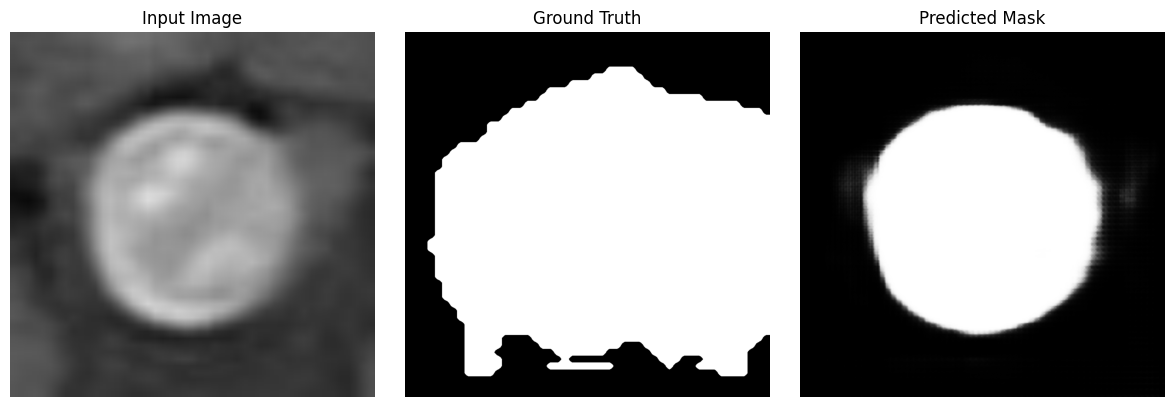

Evaluating SAM + LoRA + Image Encoder (for visualization): 100%|██████████| 478/478 [03:49<00:00,  2.08it/s]


📊 [SAM + LoRA + Image Encoder (for visualization)] Mean Dice: 0.9157, Mean IoU: 0.8586

🟥 Worst 5 Samples:
Sample 354 - Dice: 0.0106


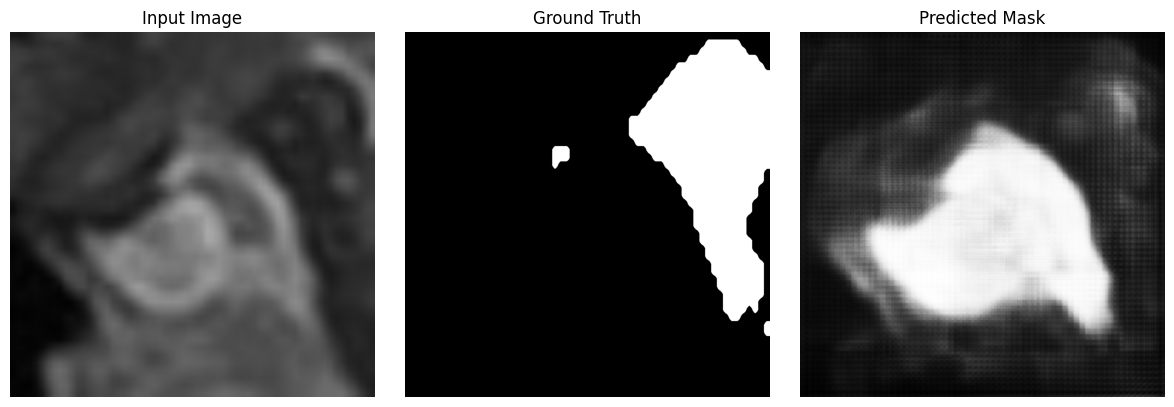

Sample 180 - Dice: 0.0202


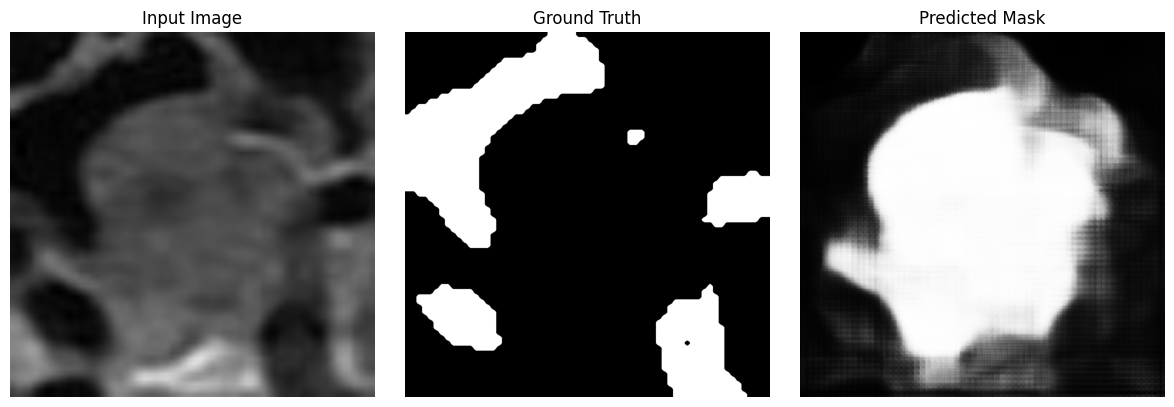

Sample 284 - Dice: 0.0288


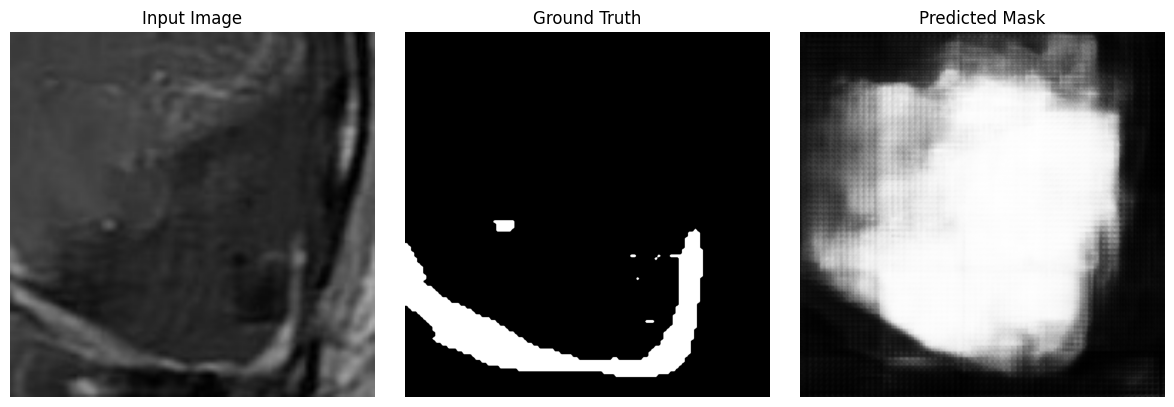

Sample 419 - Dice: 0.0446


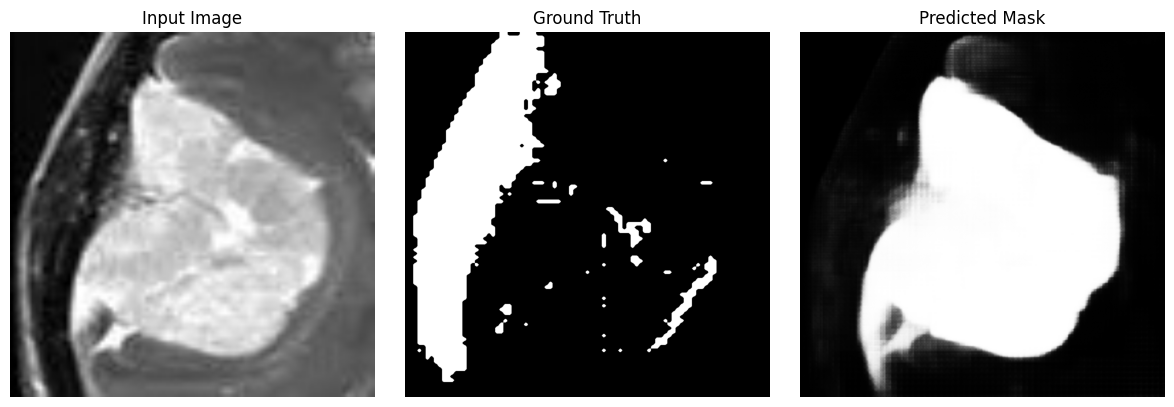

Sample 282 - Dice: 0.0779


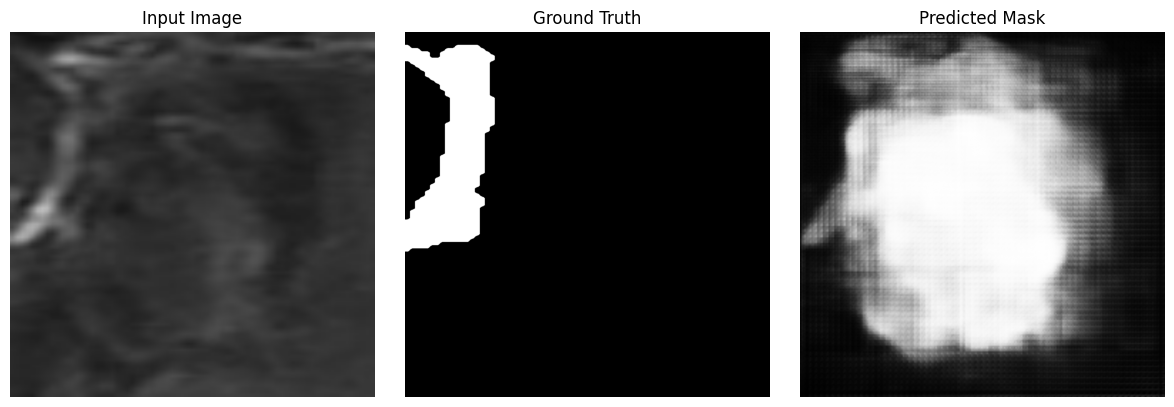


🟩 Best 5 Samples:
Sample 464 - Dice: 0.9867


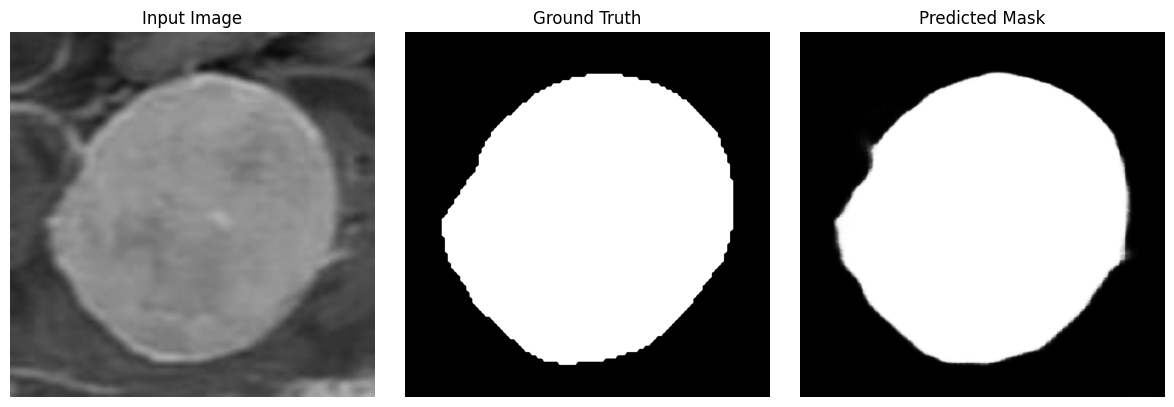

Sample 89 - Dice: 0.9843


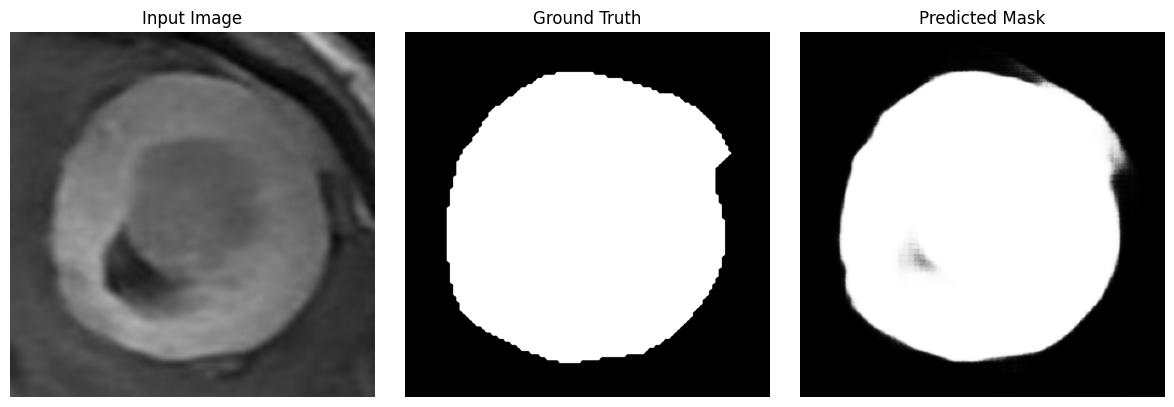

Sample 454 - Dice: 0.9838


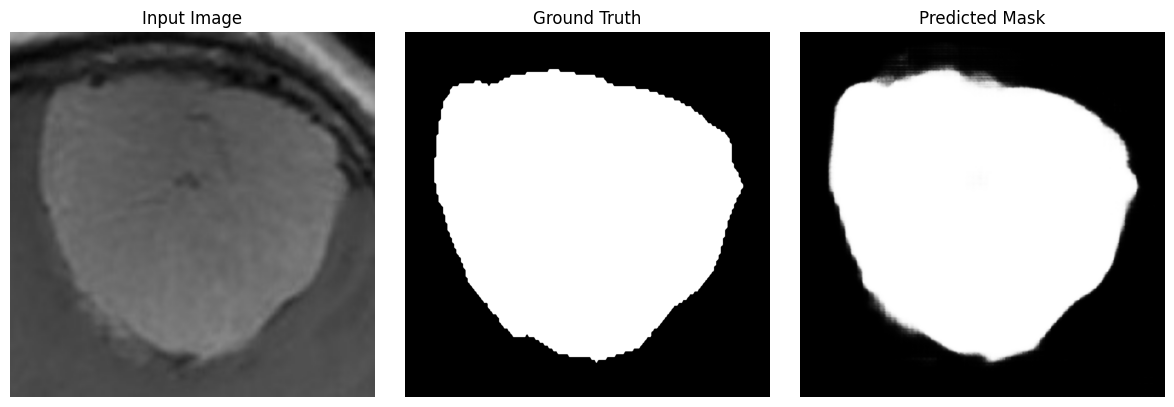

Sample 415 - Dice: 0.9835


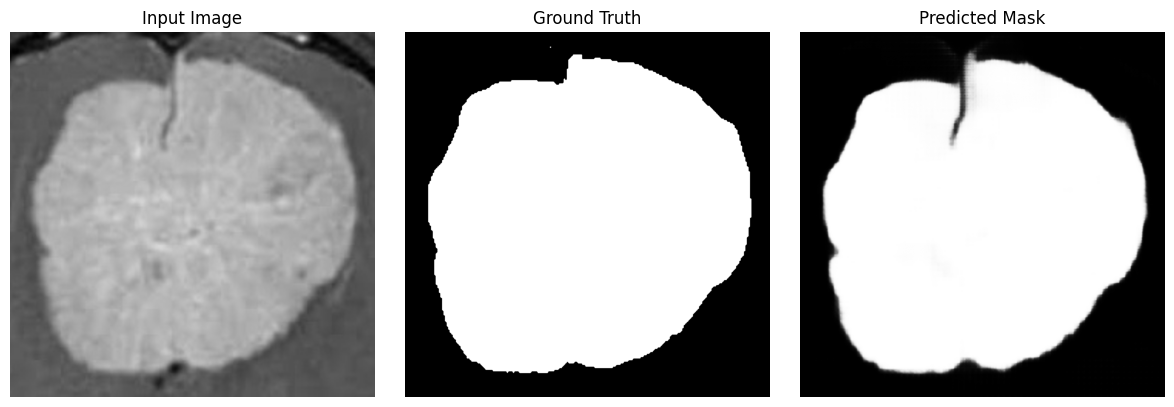

Sample 2 - Dice: 0.9835


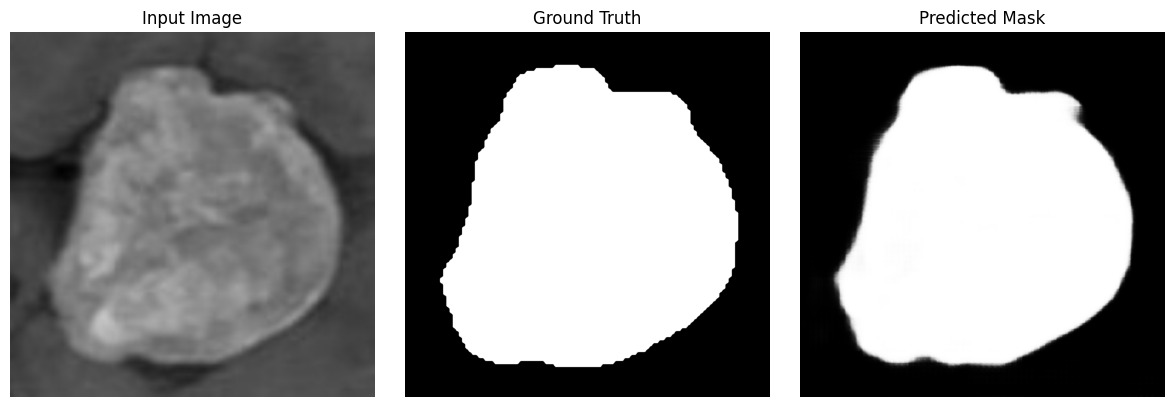

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from peft import PeftModel
from segment_anything import build_sam_vit_b
from segment_anything.utils.transforms import ResizeLongestSide
from tqdm import tqdm

# ✅ 1. Dataset for evaluation
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_size=1024):
        self.image_list = sorted(os.listdir(image_dir))
        self.mask_list = sorted(os.listdir(mask_dir))
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_size = image_size

        self.img_transform = T.Compose([
            T.Resize((image_size, image_size)),
            T.ToTensor()
        ])
        self.mask_transform = T.Compose([
            T.Resize((image_size, image_size)),
            T.ToTensor()
        ])

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_list[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_list[idx])

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        img = self.img_transform(img)
        mask = self.mask_transform(mask)
        mask = (mask > 0.5).float()

        return img, mask

# ✅ 2. Create bounding box over full image
def create_box_prompt(H=1024, W=1024):
    return torch.tensor([[[0, 0, W-1, H-1]]], dtype=torch.float, device="cuda")

# ✅ 3. Load base SAM
def load_base_sam():
    sam = build_sam_vit_b(checkpoint="/content/sam_vit_b.pth")
    sam = sam.cuda()
    sam.eval()
    return sam

# ✅ 4. Load LoRA fine-tuned SAM
def load_lora_sam():
    base_sam = build_sam_vit_b(checkpoint="/content/sam_vit_b.pth").cuda()
    peft_model_path = "/content/drive/MyDrive/fine_tune_data/sam_lora_with_imgenc"
    lora_sam = PeftModel.from_pretrained(base_sam, peft_model_path)
    lora_sam.eval()
    return lora_sam

# ✅ 5. Compute Dice and IoU
def compute_metrics(pred_mask, gt_mask):
    pred_bin = (pred_mask > 0.5).float()
    gt_bin = (gt_mask > 0.5).float()

    intersection = (pred_bin * gt_bin).sum()
    union = ((pred_bin + gt_bin) > 0).float().sum()
    dice = (2. * intersection) / (pred_bin.sum() + gt_bin.sum() + 1e-8)
    iou = intersection / (union + 1e-8)

    return dice.item(), iou.item()

# ✅ 6. Evaluation function
def evaluate_model(model, dataloader, name="Model"):
    transform = ResizeLongestSide(1024)
    model.eval()
    dice_scores, iou_scores = [], []

    with torch.no_grad():
        for img, gt_mask in tqdm(dataloader, desc=f"Evaluating {name}"):
            img, gt_mask = img.cuda(), gt_mask.cuda()
            img_np = img[0].permute(1, 2, 0).cpu().numpy()
            img_input = transform.apply_image(img_np)
            img_input = torch.from_numpy(img_input).permute(2, 0, 1).unsqueeze(0).float().cuda() / 255.0

            image_embedding = model.image_encoder(img_input)
            box_prompt = create_box_prompt()

            sparse_embeddings, dense_embeddings = model.prompt_encoder(
                points=None, boxes=box_prompt, masks=None
            )

            low_res_masks, _ = model.mask_decoder(
                image_embeddings=image_embedding,
                image_pe=model.prompt_encoder.get_dense_pe(),
                sparse_prompt_embeddings=sparse_embeddings,
                dense_prompt_embeddings=dense_embeddings,
                multimask_output=False
            )

            upsampled_masks = F.interpolate(low_res_masks, size=(1024, 1024), mode="bilinear", align_corners=False)
            pred_mask = torch.sigmoid(upsampled_masks)

            dice, iou = compute_metrics(pred_mask, gt_mask)
            dice_scores.append(dice)
            iou_scores.append(iou)

    print(f"📊 [{name}] Mean Dice: {np.mean(dice_scores):.4f}, Mean IoU: {np.mean(iou_scores):.4f}")
    return dice_scores, iou_scores

# ✅ 7. Visualize one prediction
def visualize_sample(model, dataset, index=0):
    transform = ResizeLongestSide(1024)
    img, gt_mask = dataset[index]
    img_np = img.permute(1, 2, 0).numpy()
    img_input = transform.apply_image(img_np)
    img_input = torch.from_numpy(img_input).permute(2, 0, 1).unsqueeze(0).float().cuda() / 255.0

    with torch.no_grad():
        image_embedding = model.image_encoder(img_input)
        box_prompt = create_box_prompt()

        sparse_embeddings, dense_embeddings = model.prompt_encoder(
            points=None, boxes=box_prompt, masks=None
        )

        low_res_masks, _ = model.mask_decoder(
            image_embeddings=image_embedding,
            image_pe=model.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=False
        )

        upsampled_masks = F.interpolate(low_res_masks, size=(1024, 1024), mode="bilinear", align_corners=False)
        pred_mask = torch.sigmoid(upsampled_masks).squeeze().cpu().numpy()

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(img_np)
    axs[0].set_title("Input Image")
    axs[1].imshow(gt_mask.squeeze().cpu(), cmap='gray')
    axs[1].set_title("Ground Truth")
    axs[2].imshow(pred_mask, cmap='gray')
    axs[2].set_title("Predicted Mask")
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# ✅ 8. Run everything
if __name__ == "__main__":
    val_dataset = SegmentationDataset("/content/final_val/images", "/content/final_val/masks")
    val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=2)

    sam_base = load_base_sam()
    sam_lora = load_lora_sam()

    evaluate_model(sam_base, val_dataloader, name="SAM Base")
    evaluate_model(sam_lora, val_dataloader, name="SAM + LoRA + Image Encoder")

    # Hiển thị một mẫu
    visualize_sample(sam_lora, val_dataset, index=0)
# ✅ 9. Hiển thị 5 ảnh tốt nhất và tệ nhất theo Dice score
def show_top_and_worst(model, dataset, scores, top_k=5):
    sorted_indices = np.argsort(scores)  # tăng dần
    worst_indices = sorted_indices[:top_k]
    best_indices = sorted_indices[-top_k:][::-1]  # giảm dần

    print(f"\n🟥 Worst {top_k} Samples:")
    for idx in worst_indices:
        print(f"Sample {idx} - Dice: {scores[idx]:.4f}")
        visualize_sample(model, dataset, index=idx)

    print(f"\n🟩 Best {top_k} Samples:")
    for idx in best_indices:
        print(f"Sample {idx} - Dice: {scores[idx]:.4f}")
        visualize_sample(model, dataset, index=idx)

# Gọi hàm với kết quả từ sam_lora
_, sam_lora_dice_scores = evaluate_model(sam_lora, val_dataloader, name="SAM + LoRA + Image Encoder (for visualization)")
show_top_and_worst(sam_lora, val_dataset, sam_lora_dice_scores, top_k=5)


In [ ]:
dice_scores_base, iou_scores_base = evaluate_model(sam_base, val_dataloader, name="SAM Base")
dice_scores_lora, iou_scores_lora = evaluate_model(sam_lora, val_dataloader, name="SAM + LoRA + Image Encoder")


Evaluating SAM Base: 100%|██████████| 478/478 [03:45<00:00,  2.12it/s]


📊 [SAM Base] Mean Dice: 0.6159, Mean IoU: 0.4577


Evaluating SAM + LoRA + Image Encoder: 100%|██████████| 478/478 [03:48<00:00,  2.09it/s]

📊 [SAM + LoRA + Image Encoder] Mean Dice: 0.9157, Mean IoU: 0.8586


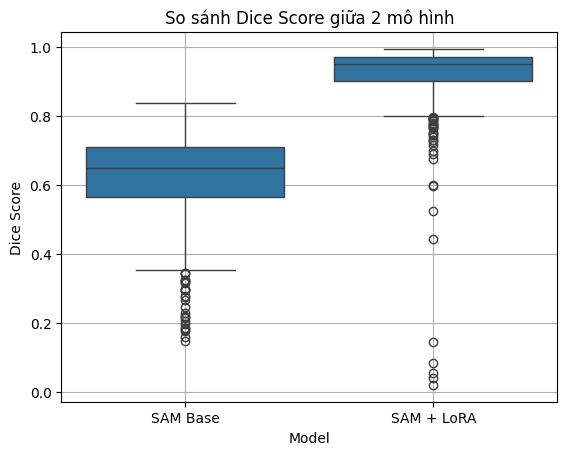

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Giả sử bạn có dice_scores_sam_base và dice_scores_sam_lora
# (kết quả từ evaluate_model)

results = {
    "Dice Score": dice_scores_base + dice_scores_lora,
    "Model": ["SAM Base"] * len(dice_scores_base) + ["SAM + LoRA"] * len(dice_scores_lora)
}

sns.boxplot(x="Model", y="Dice Score", data=results)
plt.title("So sánh Dice Score giữa 2 mô hình")
plt.grid(True)
plt.show()


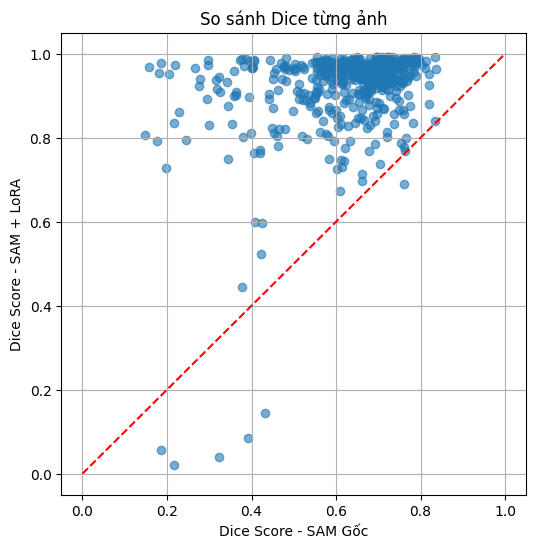

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(dice_scores_base, dice_scores_lora, alpha=0.6)
plt.plot([0, 1], [0, 1], 'r--')  # Đường chéo
plt.xlabel("Dice Score - SAM Gốc")
plt.ylabel("Dice Score - SAM + LoRA")
plt.title("So sánh Dice từng ảnh")
plt.grid(True)
plt.show()


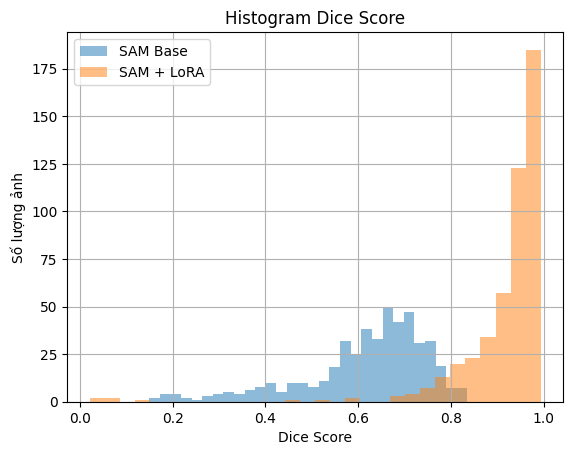

In [ ]:
plt.hist(dice_scores_base, bins=30, alpha=0.5, label="SAM Base")
plt.hist(dice_scores_lora, bins=30, alpha=0.5, label="SAM + LoRA")
plt.xlabel("Dice Score")
plt.ylabel("Số lượng ảnh")
plt.legend()
plt.title("Histogram Dice Score")
plt.grid(True)
plt.show()



📍 Hình ảnh index 464 (Dice: 0.9933)


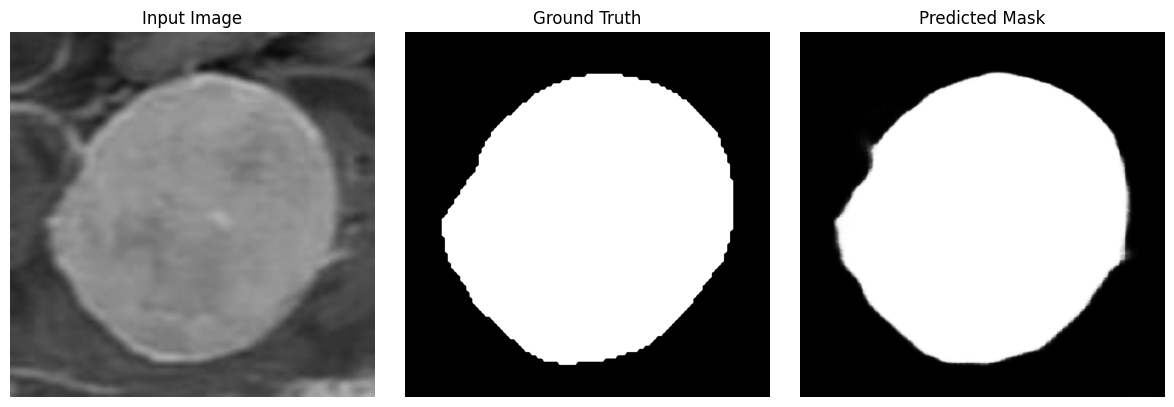


📍 Hình ảnh index 319 (Dice: 0.9502)


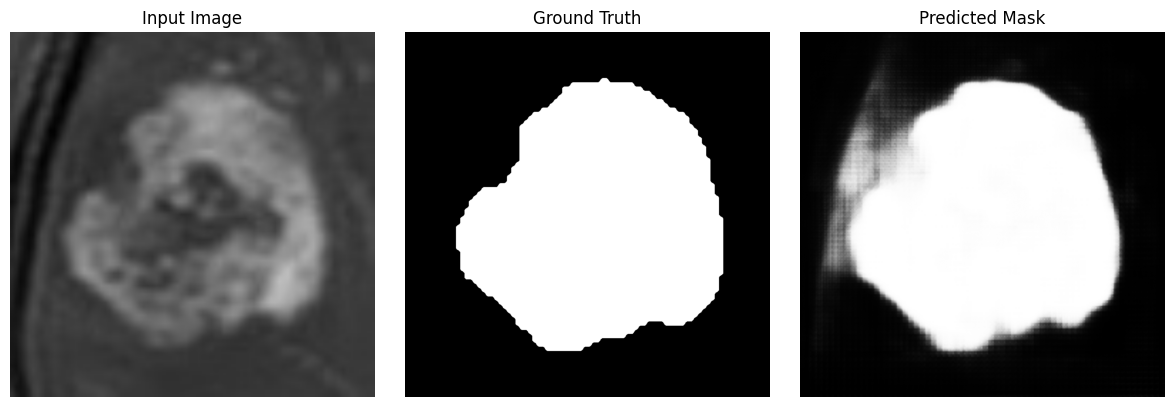


📍 Hình ảnh index 354 (Dice: 0.0210)


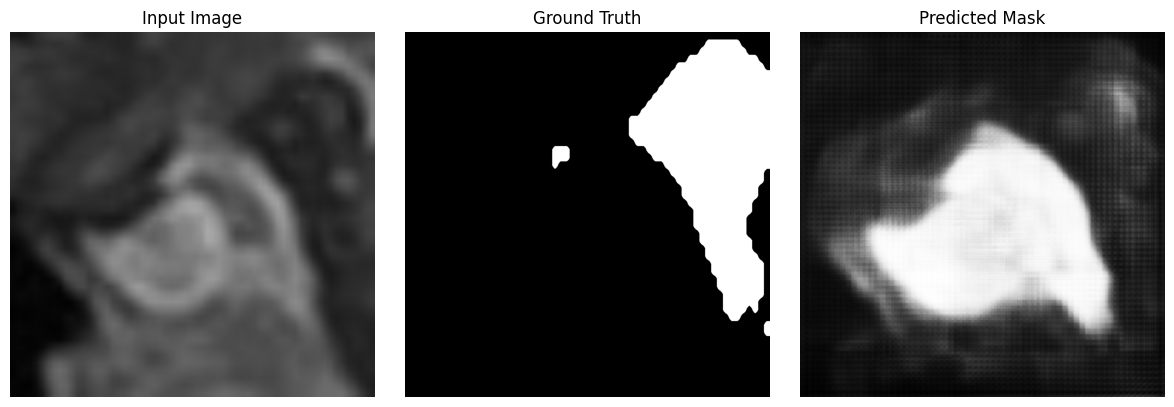

In [ ]:
import numpy as np

# Giả sử bạn đã có 2 danh sách Dice:
# dice_scores_lora và dice_scores_base

# 👉 Chọn top, mid, low theo Dice của mô hình SAM + LoRA
dice_np = np.array(dice_scores_lora)
top_idx = int(np.argmax(dice_np))          # Dice cao nhất
mid_idx = int(np.argsort(dice_np)[len(dice_np) // 2])  # Dice trung bình
low_idx = int(np.argmin(dice_np))          # Dice thấp nhất

# ✅ Hiển thị 3 ảnh đại diện
for idx in [top_idx, mid_idx, low_idx]:
    print(f"\n📍 Hình ảnh index {idx} (Dice: {dice_scores_lora[idx]:.4f})")
    visualize_sample(sam_lora, val_dataset, idx)



🔹 SAM Gốc - Index 464 (Dice: 0.7221)


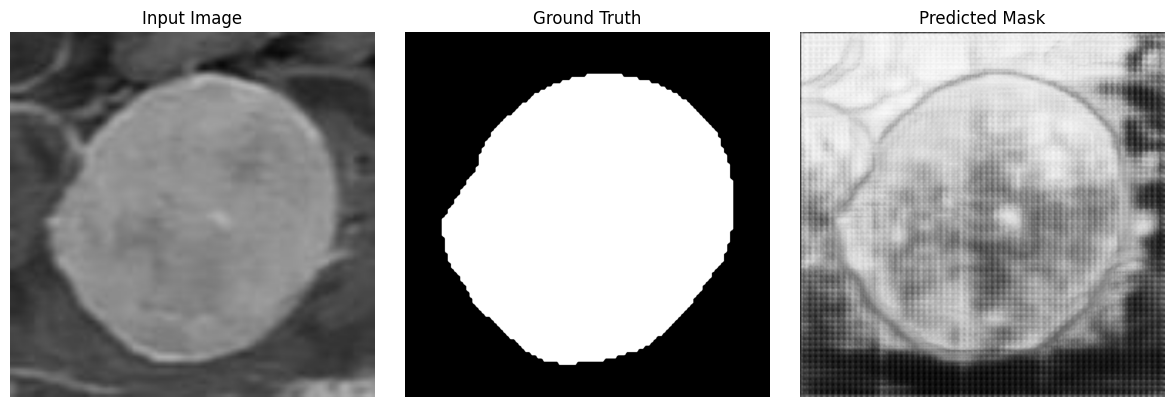

🔸 SAM + LoRA - Index 464 (Dice: 0.9933)


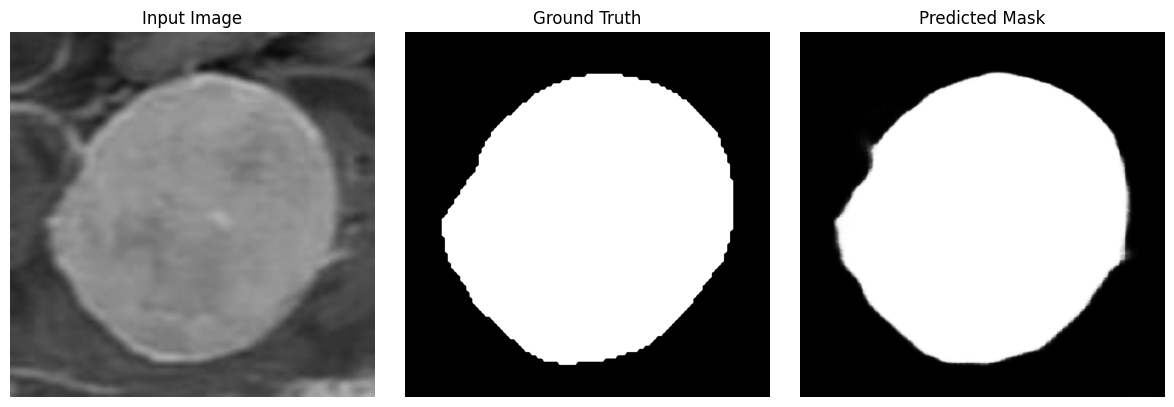


🔹 SAM Gốc - Index 319 (Dice: 0.7082)


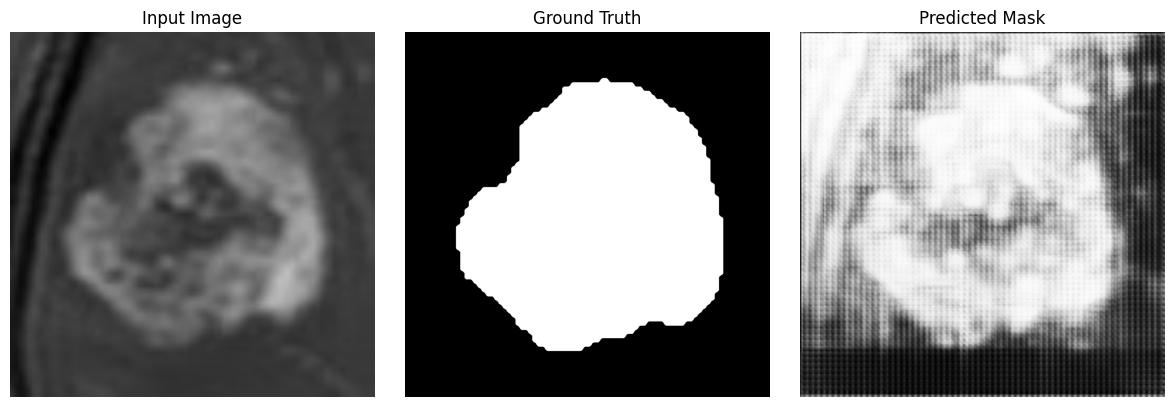

🔸 SAM + LoRA - Index 319 (Dice: 0.9502)


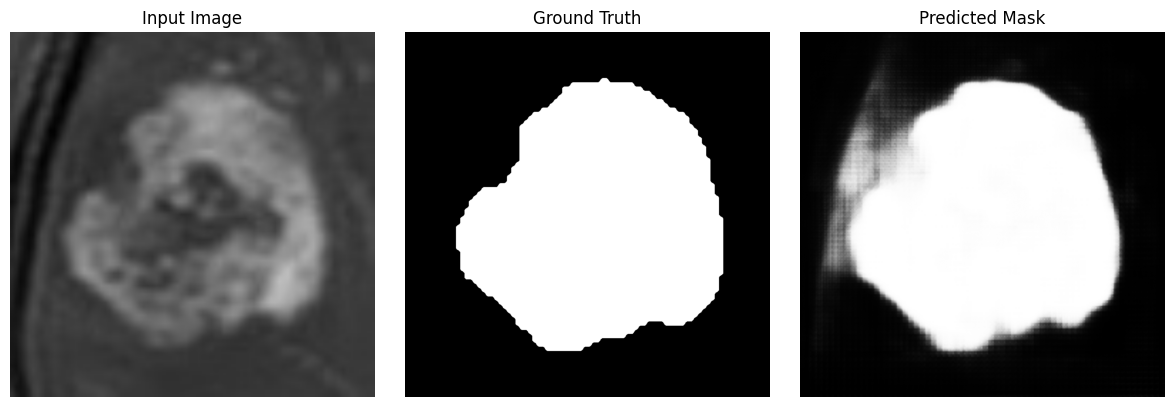


🔹 SAM Gốc - Index 354 (Dice: 0.2176)


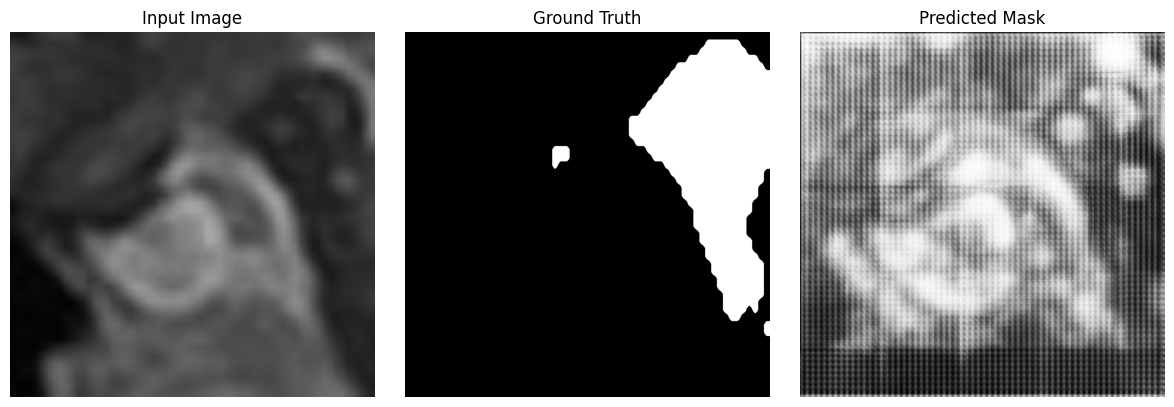

🔸 SAM + LoRA - Index 354 (Dice: 0.0210)


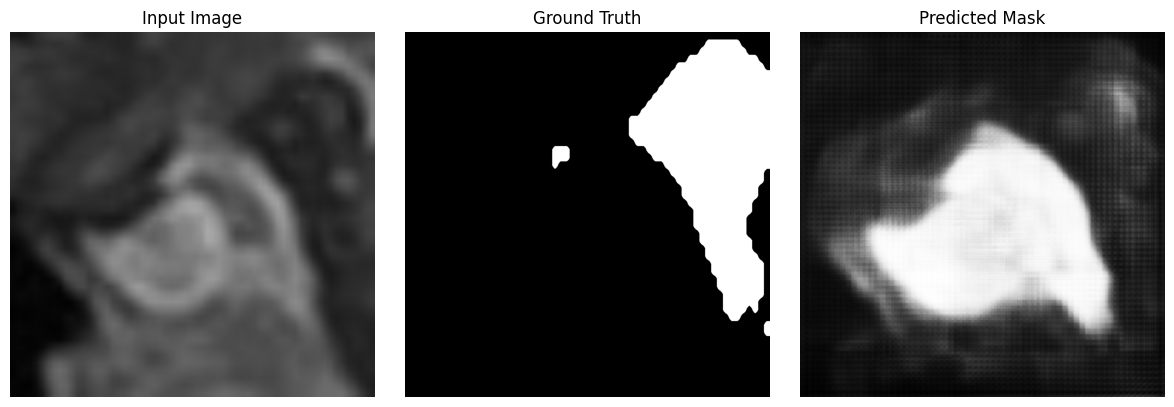

In [ ]:
for idx in [top_idx, mid_idx, low_idx]:
    print(f"\n🔹 SAM Gốc - Index {idx} (Dice: {dice_scores_base[idx]:.4f})")
    visualize_sample(sam_base, val_dataset, idx)

    print(f"🔸 SAM + LoRA - Index {idx} (Dice: {dice_scores_lora[idx]:.4f})")
    visualize_sample(sam_lora, val_dataset, idx)


📊 Đang tính chỉ số hình dạng...


100%|██████████| 478/478 [07:33<00:00,  1.05it/s]


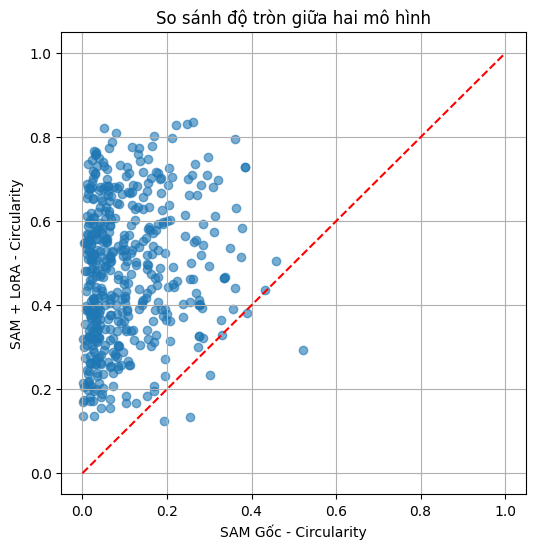


📸 Top 3 ảnh có viền khối u tròn nhất theo SAM + LoRA:
Ảnh 433 - Circularity: 0.8352


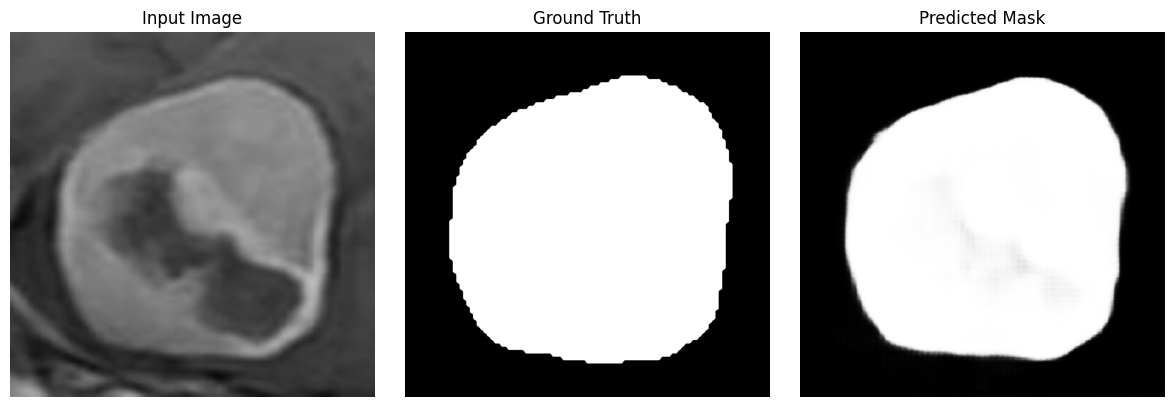

Ảnh 464 - Circularity: 0.8313


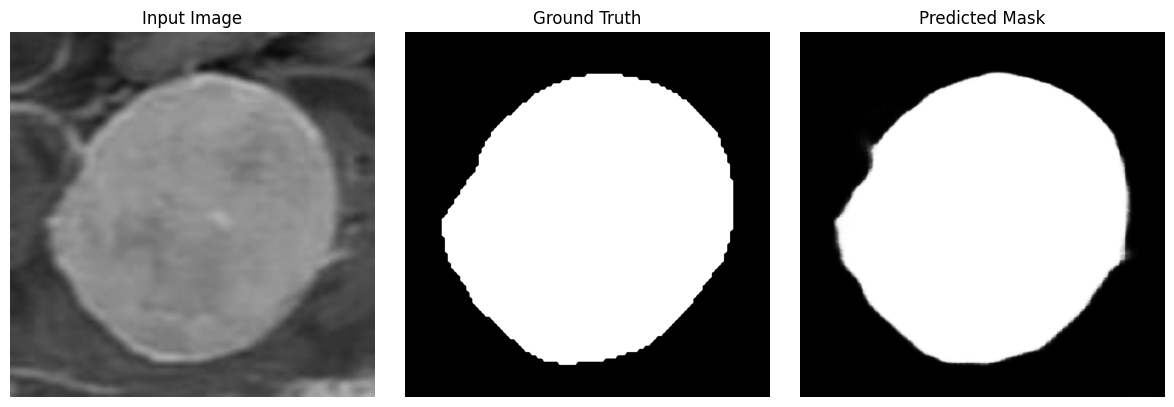

Ảnh 89 - Circularity: 0.8300


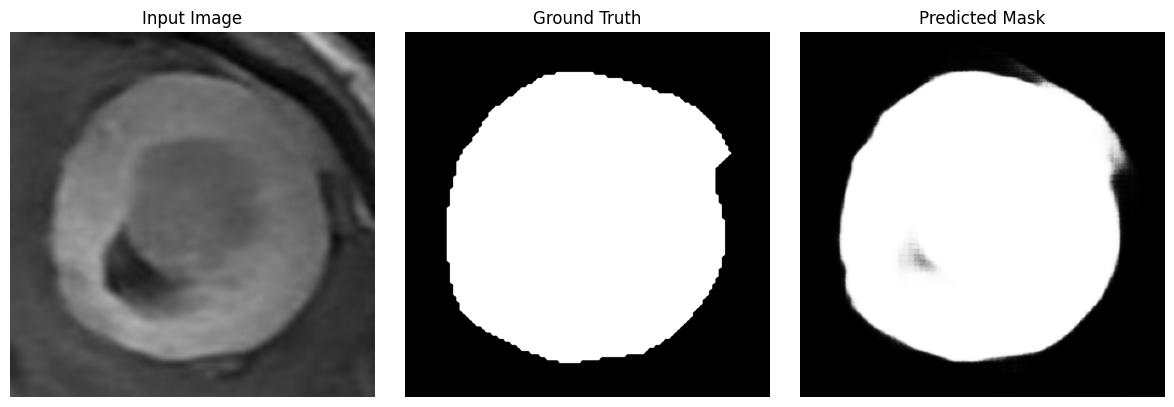


📸 Top 3 ảnh có viền khối u méo nhất theo SAM + LoRA:
Ảnh 69 - Circularity: 0.1251


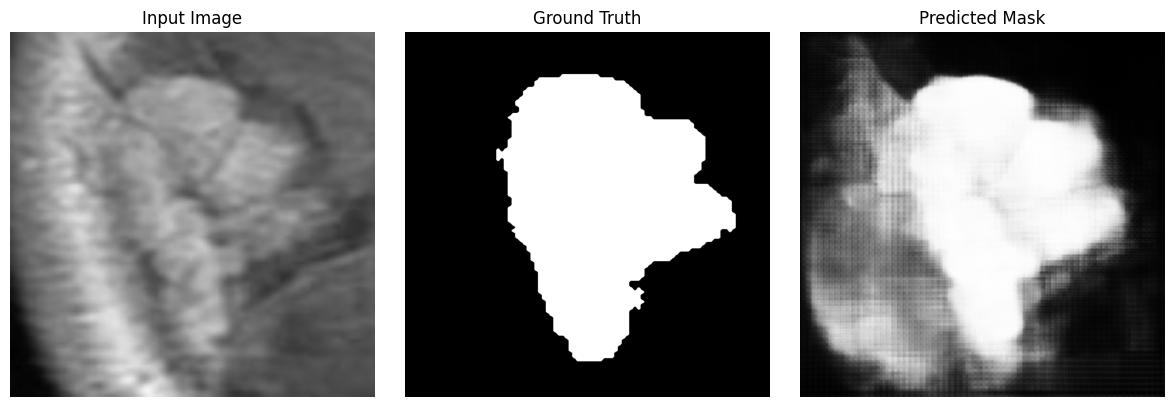

Ảnh 418 - Circularity: 0.1330


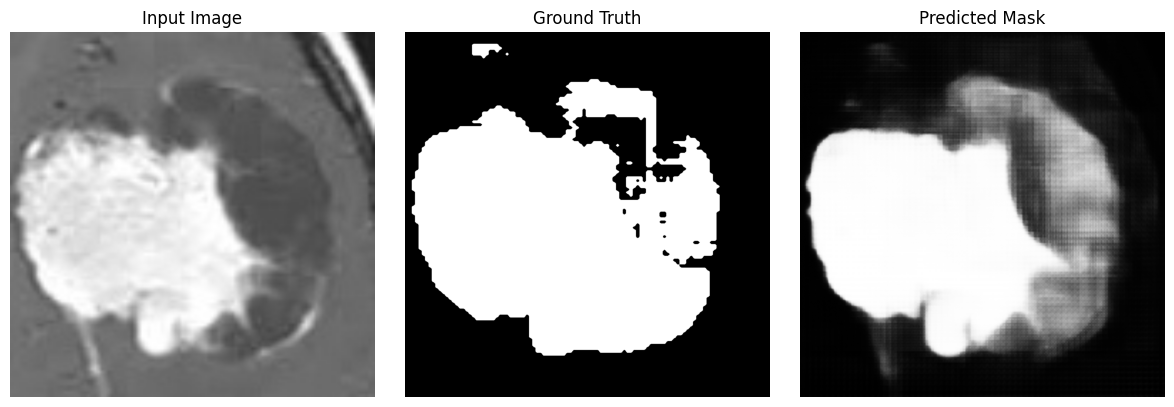

Ảnh 258 - Circularity: 0.1355


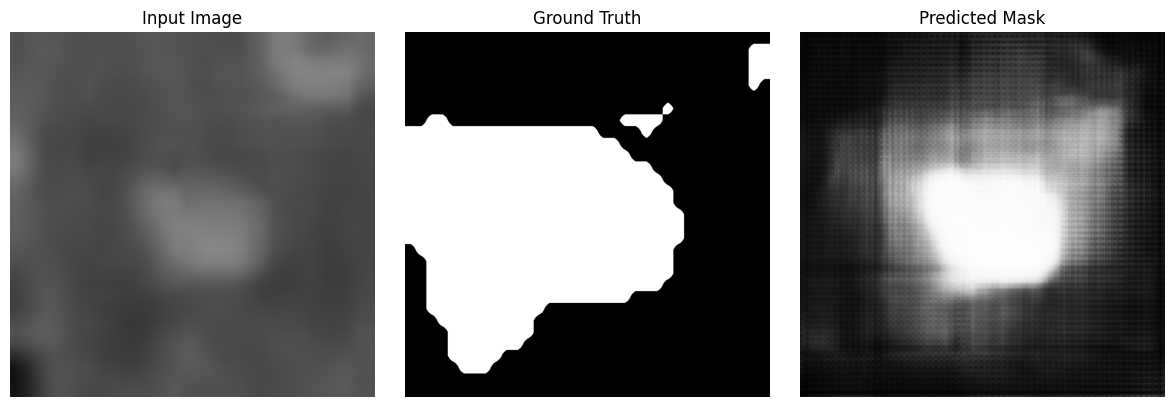

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# ⚙️ Hàm tính circularity và solidity từ predicted mask (numpy)
def compute_shape_metrics(mask):
    mask_bin = (mask > 0.5).astype(np.uint8)
    contours, _ = cv2.findContours(mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return 0.0, 0.0
    cnt = max(contours, key=cv2.contourArea)
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt, True)
    hull = cv2.convexHull(cnt)
    hull_area = cv2.contourArea(hull)

    circularity = 4 * np.pi * area / (perimeter ** 2) if perimeter > 0 else 0.0
    solidity = area / hull_area if hull_area > 0 else 0.0
    return circularity, solidity

# ⚙️ Hàm lấy mask dự đoán từ model
def get_pred_mask(model, img):
    from segment_anything.utils.transforms import ResizeLongestSide
    transform = ResizeLongestSide(1024)
    img_np = img.permute(1, 2, 0).numpy()
    img_input = transform.apply_image(img_np)
    img_input = torch.from_numpy(img_input).permute(2, 0, 1).unsqueeze(0).float().cuda() / 255.0

    with torch.no_grad():
        image_embedding = model.image_encoder(img_input)
        box_prompt = create_box_prompt()

        sparse_embeddings, dense_embeddings = model.prompt_encoder(
            points=None, boxes=box_prompt, masks=None
        )

        low_res_masks, _ = model.mask_decoder(
            image_embeddings=image_embedding,
            image_pe=model.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=False
        )

        upsampled_masks = F.interpolate(low_res_masks, size=(1024, 1024), mode="bilinear", align_corners=False)
        pred_mask = torch.sigmoid(upsampled_masks).squeeze().cpu().numpy()
    return pred_mask

# ✅ Tính cho toàn bộ tập
circularity_base, solidity_base = [], []
circularity_lora, solidity_lora = [], []

print("📊 Đang tính chỉ số hình dạng...")
for i in tqdm(range(len(val_dataset))):
    img, _ = val_dataset[i]
    pred_base = get_pred_mask(sam_base, img)
    pred_lora = get_pred_mask(sam_lora, img)

    circ_b, sol_b = compute_shape_metrics(pred_base)
    circ_l, sol_l = compute_shape_metrics(pred_lora)

    circularity_base.append(circ_b)
    solidity_base.append(sol_b)
    circularity_lora.append(circ_l)
    solidity_lora.append(sol_l)

# ✅ Vẽ biểu đồ scatter so sánh Circularity
plt.figure(figsize=(6,6))
plt.scatter(circularity_base, circularity_lora, alpha=0.6)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("SAM Gốc - Circularity")
plt.ylabel("SAM + LoRA - Circularity")
plt.title("So sánh độ tròn giữa hai mô hình")
plt.grid(True)
plt.show()

# ✅ In top 3 ảnh viền tròn nhất và méo nhất theo SAM + LoRA
top_circ_idx = np.argsort(circularity_lora)[-3:][::-1]
low_circ_idx = np.argsort(circularity_lora)[:3]

print("\n📸 Top 3 ảnh có viền khối u tròn nhất theo SAM + LoRA:")
for idx in top_circ_idx:
    print(f"Ảnh {idx} - Circularity: {circularity_lora[idx]:.4f}")
    visualize_sample(sam_lora, val_dataset, idx)

print("\n📸 Top 3 ảnh có viền khối u méo nhất theo SAM + LoRA:")
for idx in low_circ_idx:
    print(f"Ảnh {idx} - Circularity: {circularity_lora[idx]:.4f}")
    visualize_sample(sam_lora, val_dataset, idx)


In [ ]:
# 🧠 Fine-tune SAM + LoRA + Image Encoder (partial) on Custom Dataset

from segment_anything import build_sam_vit_b
from peft import LoraConfig, get_peft_model
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
from tqdm import tqdm

# ⚙️ 1. Load base SAM model
sam = build_sam_vit_b(checkpoint="/content/sam_vit_b.pth")
sam.train().cuda()

# ✅ 2. Unfreeze Image Encoder (2 blocks cuối)
for name, param in sam.image_encoder.named_parameters():
    if "blocks.10" in name or "blocks.11" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# 🧩 3. Áp dụng LoRA cho mask decoder + image encoder
target_modules = [
    # Mask decoder
    "mask_decoder.transformer.layers.0.self_attn.q_proj",
    "mask_decoder.transformer.layers.0.self_attn.v_proj",
    "mask_decoder.transformer.layers.1.self_attn.q_proj",
    "mask_decoder.transformer.layers.1.self_attn.v_proj",
    "mask_decoder.transformer.final_attn_token_to_image.q_proj",
    "mask_decoder.transformer.final_attn_token_to_image.v_proj",

    # Image encoder (ViT backbone blocks 10, 11)
    "image_encoder.blocks.10.attn.qkv",
    "image_encoder.blocks.11.attn.qkv",
]

lora_config = LoraConfig(
    r=4,
    lora_alpha=16,
    target_modules=target_modules,
    bias="none",
    task_type="FEATURE_EXTRACTION"
)

sam = get_peft_model(sam, lora_config)

# 📁 4. Custom Dataset
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_size=1024):
        self.image_list = sorted(os.listdir(image_dir))
        self.mask_list = sorted(os.listdir(mask_dir))
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_size = image_size
        self.img_transform = T.Compose([
            T.Resize((image_size, image_size)),
            T.ToTensor()
        ])
        self.mask_transform = T.Compose([
            T.Resize((image_size, image_size)),
            T.ToTensor()
        ])

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.image_dir, self.image_list[idx])).convert("RGB")
        mask = Image.open(os.path.join(self.mask_dir, self.mask_list[idx])).convert("L")
        img = self.img_transform(img)
        mask = self.mask_transform(mask)
        return img, (mask > 0.5).float()

# 🏋️‍♂️ 5. Training Loop
from segment_anything.utils.transforms import ResizeLongestSide

def create_box_prompt(H=1024, W=1024):
    return torch.tensor([[[0, 0, W-1, H-1]]], dtype=torch.float, device="cuda")

def train(model, dataloader, optimizer, epochs=10):
    model.train()
    transform = ResizeLongestSide(1024)
    for epoch in range(epochs):
        total_loss = 0
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")
        for img, gt_mask in pbar:
            img, gt_mask = img.cuda(), gt_mask.cuda()
            img_np = img[0].permute(1, 2, 0).cpu().numpy()
            img_input = transform.apply_image(img_np)
            img_input = torch.from_numpy(img_input).permute(2, 0, 1).unsqueeze(0).float().cuda() / 255.0

            image_embedding = model.image_encoder(img_input)
            box_prompt = create_box_prompt()

            sparse_embeddings, dense_embeddings = model.prompt_encoder(
                points=None, boxes=box_prompt, masks=None
            )

            low_res_masks, _ = model.mask_decoder(
                image_embeddings=image_embedding,
                image_pe=model.prompt_encoder.get_dense_pe(),
                sparse_prompt_embeddings=sparse_embeddings,
                dense_prompt_embeddings=dense_embeddings,
                multimask_output=False
            )

            upsampled_masks = F.interpolate(low_res_masks, size=(1024, 1024), mode="bilinear", align_corners=False)
            loss = F.binary_cross_entropy_with_logits(upsampled_masks, gt_mask)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pbar.set_postfix({"loss": loss.item()})
        print(f"✅ Epoch {epoch+1} hoàn tất - Total Loss: {total_loss:.4f}")

# 🚀 6. Prepare dataloader & optimizer
train_dataset = SegmentationDataset("/content/final_train/images", "/content/final_train/masks")
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=2)

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, sam.parameters()), lr=1e-4)

# 🔥 7. Train
train(sam, train_dataloader, optimizer, epochs=10)

# 💾 8. Save adapter + image encoder (FULL state_dict)
# 8.1. Save PEFT adapter (LoRA only)
sam.save_pretrained("/content/drive/MyDrive/fine_tune_data/sam_lora_with_imgenc")

# 8.2. Save full model including image_encoder
torch.save(sam.state_dict(), "/content/drive/MyDrive/fine_tune_data/sam_lora_full.pth")


Epoch 1/10: 100%|██████████| 4846/4846 [46:49<00:00,  1.73it/s, loss=0.0538]


✅ Epoch 1 hoàn tất - Total Loss: 1246.9240


Epoch 2/10: 100%|██████████| 4846/4846 [46:52<00:00,  1.72it/s, loss=0.169]


✅ Epoch 2 hoàn tất - Total Loss: 1057.4879


Epoch 3/10: 100%|██████████| 4846/4846 [46:53<00:00,  1.72it/s, loss=0.0765]


✅ Epoch 3 hoàn tất - Total Loss: 1019.7899


Epoch 4/10: 100%|██████████| 4846/4846 [46:54<00:00,  1.72it/s, loss=0.156]


✅ Epoch 4 hoàn tất - Total Loss: 995.0499


Epoch 5/10: 100%|██████████| 4846/4846 [46:56<00:00,  1.72it/s, loss=0.365]


✅ Epoch 5 hoàn tất - Total Loss: 974.5559


Epoch 6/10: 100%|██████████| 4846/4846 [46:52<00:00,  1.72it/s, loss=0.267]


✅ Epoch 6 hoàn tất - Total Loss: 961.5138


Epoch 7/10: 100%|██████████| 4846/4846 [46:51<00:00,  1.72it/s, loss=0.0595]


✅ Epoch 7 hoàn tất - Total Loss: 948.9179


Epoch 8/10: 100%|██████████| 4846/4846 [46:54<00:00,  1.72it/s, loss=0.0725]


✅ Epoch 8 hoàn tất - Total Loss: 932.5429


Epoch 9/10: 100%|██████████| 4846/4846 [46:53<00:00,  1.72it/s, loss=0.0418]


✅ Epoch 9 hoàn tất - Total Loss: 919.3677


Epoch 10/10: 100%|██████████| 4846/4846 [46:55<00:00,  1.72it/s, loss=0.0335]


✅ Epoch 10 hoàn tất - Total Loss: 907.1809


In [ ]:
# 🧠 Fine-tune SAM + LoRA + Image Encoder on Custom Dataset

from segment_anything import build_sam_vit_b
from peft import LoraConfig, get_peft_model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from PIL import Image
import os

# ⚙️ 1. Load base SAM model
sam = build_sam_vit_b(checkpoint="/content/sam_vit_b.pth")
sam.train().cuda()

# ✅ 2. Unfreeze Image Encoder (full or partial)
for name, param in sam.image_encoder.named_parameters():
    if "blocks.10" in name or "blocks.11" in name:
        param.requires_grad = True  # partial fine-tune (2 last blocks)
    else:
        param.requires_grad = False

# 🧩 3. Apply LoRA to Mask Decoder
lora_config = LoraConfig(
    r=4,
    lora_alpha=16,
    target_modules=[
        "mask_decoder.transformer.layers.0.self_attn.q_proj",
        "mask_decoder.transformer.layers.0.self_attn.v_proj",
        "mask_decoder.transformer.layers.1.self_attn.q_proj",
        "mask_decoder.transformer.layers.1.self_attn.v_proj",
        "mask_decoder.transformer.final_attn_token_to_image.q_proj",
        "mask_decoder.transformer.final_attn_token_to_image.v_proj"
    ],
    bias="none",
    task_type="FEATURE_EXTRACTION"
)
sam = get_peft_model(sam, lora_config)

# 📁 4. Custom Segmentation Dataset
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_size=1024):
        self.image_list = sorted(os.listdir(image_dir))
        self.mask_list = sorted(os.listdir(mask_dir))
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_size = image_size

        self.img_transform = T.Compose([
            T.Resize((image_size, image_size)),
            T.ToTensor()
        ])
        self.mask_transform = T.Compose([
            T.Resize((image_size, image_size)),
            T.ToTensor()
        ])

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_list[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_list[idx])

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        img = self.img_transform(img)
        mask = self.mask_transform(mask)
        mask = (mask > 0.5).float()

        return img, mask

# 🏋️‍♂️ 5. Training Loop
from segment_anything.utils.transforms import ResizeLongestSide
from tqdm import tqdm

def create_box_prompt(H=1024, W=1024):
    return torch.tensor([[[0, 0, W-1, H-1]]], dtype=torch.float, device="cuda")

def train(model, dataloader, optimizer, epochs=10):
    model.train()
    transform = ResizeLongestSide(1024)

    for epoch in range(epochs):
        total_loss = 0
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")

        for img, gt_mask in pbar:
            img, gt_mask = img.cuda(), gt_mask.cuda()
            img_np = img[0].permute(1, 2, 0).cpu().numpy()
            img_input = transform.apply_image(img_np)
            img_input = torch.from_numpy(img_input).permute(2, 0, 1).unsqueeze(0).float().cuda() / 255.0

            image_embedding = model.image_encoder(img_input)
            box_prompt = create_box_prompt()

            sparse_embeddings, dense_embeddings = model.prompt_encoder(
                points=None, boxes=box_prompt, masks=None
            )

            low_res_masks, _ = model.mask_decoder(
                image_embeddings=image_embedding,
                image_pe=model.prompt_encoder.get_dense_pe(),
                sparse_prompt_embeddings=sparse_embeddings,
                dense_prompt_embeddings=dense_embeddings,
                multimask_output=False
            )

            upsampled_masks = F.interpolate(low_res_masks, size=(1024, 1024), mode="bilinear", align_corners=False)
            loss = F.binary_cross_entropy_with_logits(upsampled_masks, gt_mask)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pbar.set_postfix({"loss": loss.item()})

        print(f"✅ Epoch {epoch+1} hoàn tất - Total Loss: {total_loss:.4f}")

# 🚀 6. Dataloader & Optimizer
train_dataset = SegmentationDataset("/content/final_train/images", "/content/final_train/masks")
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=2)

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, sam.parameters()), lr=1e-4)

# 🔥 7. Start Training
train(sam, train_dataloader, optimizer, epochs=10)

# 💾 8. Save model
sam.save_pretrained("/content/drive/MyDrive/fine_tune_data/sam_lora_with_image_encoder")


Epoch 1/10: 100%|██████████| 4846/4846 [43:52<00:00,  1.84it/s, loss=0.263]


✅ Epoch 1 hoàn tất - Total Loss: 1512.7287


Epoch 2/10: 100%|██████████| 4846/4846 [44:04<00:00,  1.83it/s, loss=0.16]


✅ Epoch 2 hoàn tất - Total Loss: 1300.6776


Epoch 3/10: 100%|██████████| 4846/4846 [44:07<00:00,  1.83it/s, loss=0.178]


✅ Epoch 3 hoàn tất - Total Loss: 1262.5223


Epoch 4/10: 100%|██████████| 4846/4846 [44:08<00:00,  1.83it/s, loss=0.215]


✅ Epoch 4 hoàn tất - Total Loss: 1239.0095


Epoch 5/10: 100%|██████████| 4846/4846 [44:07<00:00,  1.83it/s, loss=0.149]


✅ Epoch 5 hoàn tất - Total Loss: 1218.4332


Epoch 6/10: 100%|██████████| 4846/4846 [44:04<00:00,  1.83it/s, loss=0.27]


✅ Epoch 6 hoàn tất - Total Loss: 1204.8358


Epoch 7/10: 100%|██████████| 4846/4846 [44:04<00:00,  1.83it/s, loss=0.279]


✅ Epoch 7 hoàn tất - Total Loss: 1191.5550


Epoch 8/10: 100%|██████████| 4846/4846 [44:06<00:00,  1.83it/s, loss=0.353]


✅ Epoch 8 hoàn tất - Total Loss: 1179.0458


Epoch 9/10: 100%|██████████| 4846/4846 [44:07<00:00,  1.83it/s, loss=0.17]


✅ Epoch 9 hoàn tất - Total Loss: 1173.0134


Epoch 10/10: 100%|██████████| 4846/4846 [44:05<00:00,  1.83it/s, loss=0.0399]

✅ Epoch 10 hoàn tất - Total Loss: 1166.6797


In [ ]:
from segment_anything.utils.transforms import ResizeLongestSide
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm  # ✅ Tiến trình rõ ràng

transform = ResizeLongestSide(1024)
optimizer = optim.AdamW(sam.parameters(), lr=1e-4)

def create_box_prompt(H=1024, W=1024):
    return torch.tensor([[[0, 0, W-1, H-1]]], dtype=torch.float, device="cuda")

for epoch in range(5):
    sam.train()
    total_loss = 0
    loop = tqdm(dataloader, desc=f"Epoch {epoch+1}", leave=True)

    for img, gt_mask, _ in loop:
        img, gt_mask = img.cuda(), gt_mask.cuda()
        img_np = img[0].permute(1, 2, 0).cpu().numpy()
        img_input = transform.apply_image(img_np)
        img_input = torch.from_numpy(img_input).permute(2, 0, 1).unsqueeze(0).float().cuda() / 255.0

        image_embedding = sam.image_encoder(img_input)
        box_prompt = create_box_prompt()

        sparse_embeddings, dense_embeddings = sam.prompt_encoder(
            points=None, boxes=box_prompt, masks=None
        )

        low_res_masks, _ = sam.mask_decoder(  # ✅ Sửa lỗi unpack
            image_embeddings=image_embedding,
            image_pe=sam.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=False
        )

        upsampled_masks = torch.nn.functional.interpolate(
            low_res_masks, size=(1024, 1024), mode="bilinear", align_corners=False
        )
        loss = F.binary_cross_entropy_with_logits(upsampled_masks, gt_mask)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    print(f"\n✅ Epoch {epoch+1} hoàn tất - Total Loss: {total_loss:.4f}\\n")


KeyboardInterrupt: 

🎯 Tổng số tham số đang huấn luyện: 11264


Epoch 1/15: 100%|██████████| 4846/4846 [40:30<00:00,  1.99it/s, loss=0.163]


✅ Epoch 1 hoàn tất - Total Loss: 1520.6312


Epoch 2/15: 100%|██████████| 4846/4846 [40:32<00:00,  1.99it/s, loss=0.387]


✅ Epoch 2 hoàn tất - Total Loss: 1304.2705


Epoch 3/15: 100%|██████████| 4846/4846 [40:34<00:00,  1.99it/s, loss=0.0393]


✅ Epoch 3 hoàn tất - Total Loss: 1263.3541


Epoch 4/15: 100%|██████████| 4846/4846 [40:33<00:00,  1.99it/s, loss=0.0399]


✅ Epoch 4 hoàn tất - Total Loss: 1246.4754


Epoch 5/15: 100%|██████████| 4846/4846 [40:37<00:00,  1.99it/s, loss=0.285]


✅ Epoch 5 hoàn tất - Total Loss: 1231.5016


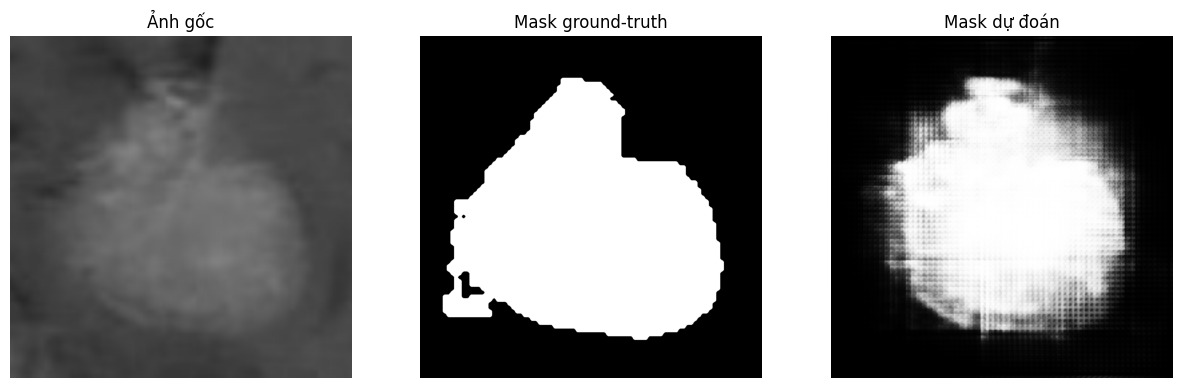

Epoch 6/15: 100%|██████████| 4846/4846 [40:35<00:00,  1.99it/s, loss=0.144]


✅ Epoch 6 hoàn tất - Total Loss: 1218.5945


Epoch 7/15: 100%|██████████| 4846/4846 [40:38<00:00,  1.99it/s, loss=0.189]


✅ Epoch 7 hoàn tất - Total Loss: 1211.5410


Epoch 8/15: 100%|██████████| 4846/4846 [40:36<00:00,  1.99it/s, loss=0.17]


✅ Epoch 8 hoàn tất - Total Loss: 1200.1707


Epoch 9/15: 100%|██████████| 4846/4846 [40:32<00:00,  1.99it/s, loss=0.362]


✅ Epoch 9 hoàn tất - Total Loss: 1196.2201


Epoch 10/15: 100%|██████████| 4846/4846 [40:30<00:00,  1.99it/s, loss=0.203]


✅ Epoch 10 hoàn tất - Total Loss: 1184.3381


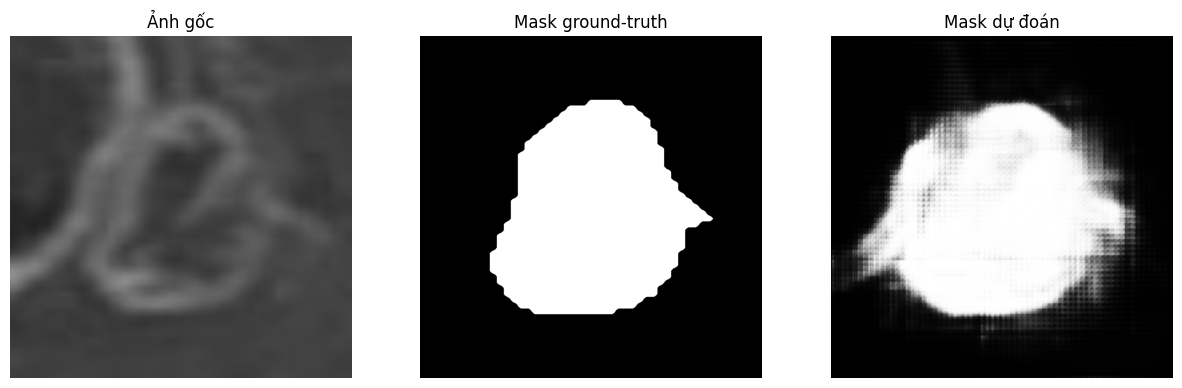

Epoch 11/15: 100%|██████████| 4846/4846 [40:30<00:00,  1.99it/s, loss=0.179]


✅ Epoch 11 hoàn tất - Total Loss: 1179.9612


Epoch 12/15: 100%|██████████| 4846/4846 [40:32<00:00,  1.99it/s, loss=0.292]


✅ Epoch 12 hoàn tất - Total Loss: 1182.9093


Epoch 13/15: 100%|██████████| 4846/4846 [40:31<00:00,  1.99it/s, loss=0.209]


✅ Epoch 13 hoàn tất - Total Loss: 1167.7626


Epoch 14/15: 100%|██████████| 4846/4846 [40:30<00:00,  1.99it/s, loss=0.116]


✅ Epoch 14 hoàn tất - Total Loss: 1165.9969


Epoch 15/15: 100%|██████████| 4846/4846 [40:31<00:00,  1.99it/s, loss=0.0837]


✅ Epoch 15 hoàn tất - Total Loss: 1161.5167


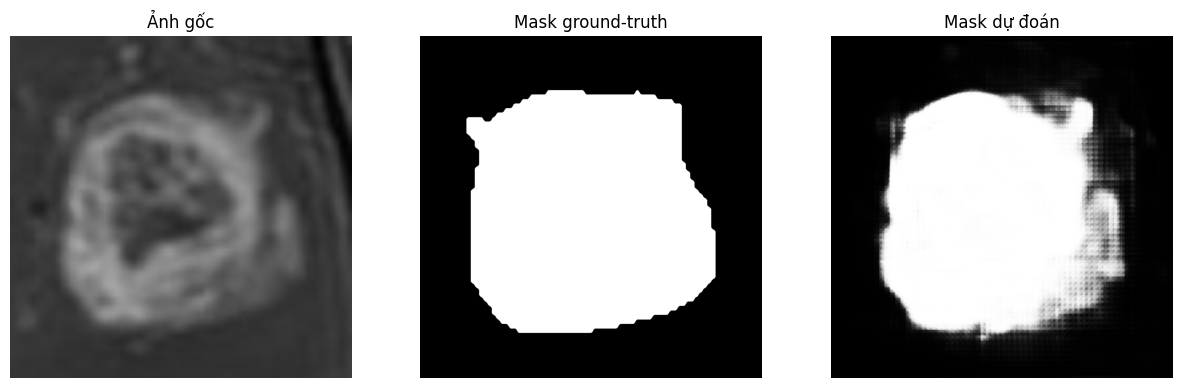

In [ ]:
from segment_anything.utils.transforms import ResizeLongestSide
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

# Resize ảnh về đúng input cho SAM
transform = ResizeLongestSide(1024)

# Optimizer
optimizer = optim.AdamW(sam.parameters(), lr=1e-4)

# Hàm tạo box prompt toàn ảnh
def create_box_prompt(H=1024, W=1024):
    return torch.tensor([[[0, 0, W-1, H-1]]], dtype=torch.float, device="cuda")

# Hàm visualize ảnh và mask
def visualize(img, gt_mask, pred_mask):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(img.permute(1, 2, 0).cpu())
    axs[0].set_title("Ảnh gốc")
    axs[1].imshow(gt_mask.squeeze().cpu(), cmap='gray')
    axs[1].set_title("Mask ground-truth")
    axs[2].imshow(pred_mask.squeeze(), cmap='gray')
    axs[2].set_title("Mask dự đoán")
    for ax in axs: ax.axis('off')
    plt.show()

# In số tham số được huấn luyện
trainable_params = sum(p.numel() for p in sam.parameters() if p.requires_grad)
print(f"🎯 Tổng số tham số đang huấn luyện: {trainable_params}")

# Huấn luyện 15 epoch
for epoch in range(15):
    sam.train()
    total_loss = 0
    loop = tqdm(dataloader, desc=f"Epoch {epoch+1}/15", leave=True)

    for img, gt_mask, _ in loop:
        img, gt_mask = img.cuda(), gt_mask.cuda()

        # Resize ảnh đầu vào đúng chuẩn SAM
        img_np = img[0].permute(1, 2, 0).cpu().numpy()
        img_input = transform.apply_image(img_np)
        img_input = torch.from_numpy(img_input).permute(2, 0, 1).unsqueeze(0).float().cuda() / 255.0

        # Trích xuất embedding ảnh
        with torch.no_grad():
            image_embedding = sam.image_encoder(img_input)

        # Prompt
        box_prompt = create_box_prompt()

        # Trích xuất embedding từ prompt
        sparse_embeddings, dense_embeddings = sam.prompt_encoder(
            points=None, boxes=box_prompt, masks=None
        )

        # Dự đoán mask từ decoder
        low_res_masks, _ = sam.mask_decoder(
            image_embeddings=image_embedding,
            image_pe=sam.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=False
        )

        # Upsample mask về kích thước gốc
        upsampled_masks = F.interpolate(
            low_res_masks, size=(1024, 1024), mode="bilinear", align_corners=False
        )

        # Tính loss
        loss = F.binary_cross_entropy_with_logits(upsampled_masks, gt_mask)

        # Cập nhật tham số
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(sam.parameters(), 1.0)  # gradient clipping
        optimizer.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    print(f"✅ Epoch {epoch+1} hoàn tất - Total Loss: {total_loss:.4f}")

    # Visualize mỗi 5 epoch
    if (epoch + 1) % 5 == 0:
        with torch.no_grad():
            pred_mask = torch.sigmoid(upsampled_masks)
            visualize(img[0], gt_mask[0], pred_mask[0].detach().cpu())


In [ ]:
# Nếu sam là PeftModel
sam.save_pretrained("/content/drive/MyDrive/fine_tune_data/sam_lora_vitb_final_15ep")


In [ ]:
# from segment_anything import sam_model_registry
# from peft import get_peft_model, LoraConfig, TaskType
# import torch

# # Load mô hình gốc SAM vit_b
# sam = sam_model_registry["vit_b"](checkpoint="/content/sam_vit_b.pth")

# # Gắn LoRA với đúng cấu hình bạn dùng khi huấn luyện
# lora_config = LoraConfig(
#     r=4,
#     lora_alpha=16,
#     target_modules=[
#         "mask_decoder.transformer.layers.0.self_attn.q_proj",
#         "mask_decoder.transformer.layers.0.self_attn.v_proj",
#         "mask_decoder.transformer.layers.1.self_attn.q_proj",
#         "mask_decoder.transformer.layers.1.self_attn.v_proj",
#         "mask_decoder.transformer.final_attn_token_to_image.q_proj",
#         "mask_decoder.transformer.final_attn_token_to_image.v_proj"
#     ],
#     lora_dropout=0.0,
#     bias="none",
#     task_type=TaskType.FEATURE_EXTRACTION
# )

# sam = get_peft_model(sam, lora_config)


In [ ]:
# ckpt_path = "/content/drive/MyDrive/fine_tune_data/sam_lora_vitb_final.pt"
# state_dict = torch.load(ckpt_path)

# # Load đúng vào mô hình LoRA
# sam.load_state_dict(state_dict, strict=False)
# sam.eval().cuda()


In [ ]:
# import os
# import numpy as np
# import torch
# from PIL import Image
# import matplotlib.pyplot as plt
# from segment_anything.utils.transforms import ResizeLongestSide
# from torchvision.transforms.functional import pad

# # --- Đường dẫn ---
# image_dir = "/content/drive/MyDrive/fine_tune_data/final_train/images"
# sample_name = next(f for f in os.listdir(image_dir) if f.endswith(".jpg"))
# image_path = os.path.join(image_dir, sample_name)

# # --- Load ảnh ---
# image_pil = Image.open(image_path).convert("RGB")
# original_size = image_pil.size  # (W, H)

# # --- Resize ảnh giữ nguyên tỷ lệ ---
# transform = ResizeLongestSide(1024)
# image_resized = transform.apply_image(np.array(image_pil))  # (H, W, C)
# image_tensor = torch.from_numpy(image_resized).permute(2, 0, 1).float() / 255.0  # (C, H, W)

# # --- Pad đều 2 bên để thành (1024, 1024) ---
# _, h, w = image_tensor.shape
# pad_h = 1024 - h
# pad_w = 1024 - w
# pad_top = pad_h // 2
# pad_bottom = pad_h - pad_top
# pad_left = pad_w // 2
# pad_right = pad_w - pad_left
# image_tensor = pad(image_tensor, [pad_left, pad_top, pad_right, pad_bottom])  # left, top, right, bottom

# # --- Chuẩn bị tensor input ---
# image_tensor = image_tensor.unsqueeze(0).cuda()  # (1, 3, 1024, 1024)

# # --- Tạo box prompt toàn ảnh ---
# box_prompt = torch.tensor([[[0, 0, 1023, 1023]]], dtype=torch.float, device="cuda")

# # --- Dự đoán mask ---
# with torch.no_grad():
#     image_embedding = sam.image_encoder(image_tensor)
#     sparse_embeddings, dense_embeddings = sam.prompt_encoder(
#         points=None, boxes=box_prompt, masks=None
#     )
#     low_res_masks, _ = sam.mask_decoder(
#         image_embeddings=image_embedding,
#         image_pe=sam.prompt_encoder.get_dense_pe(),
#         sparse_prompt_embeddings=sparse_embeddings,
#         dense_prompt_embeddings=dense_embeddings,
#         multimask_output=False
#     )
#     pred_mask = torch.nn.functional.interpolate(
#         low_res_masks, size=(1024, 1024), mode="bilinear", align_corners=False
#     ).sigmoid().squeeze().cpu().numpy()

# # --- Hiển thị kết quả ---
# plt.figure(figsize=(10, 5))
# plt.imshow(image_pil.resize((1024, 1024)))  # ảnh gốc resize để hiển thị khớp
# plt.imshow(pred_mask > 0.5, alpha=0.5, cmap="jet")
# plt.title(f"Ảnh: {sample_name} - Mask từ SAM + LoRA")
# plt.axis("off")
# plt.show()


In [ ]:
# import os
# import random
# import numpy as np
# import torch
# from PIL import Image
# import matplotlib.pyplot as plt

# # --- Đường dẫn ---
# image_dir = "/content/drive/MyDrive/fine_tune_data/final_train/images"
# mask_dir = "/content/drive/MyDrive/fine_tune_data/final_train/masks"

# # --- Lấy ảnh và mask bất kỳ ---
# sample_name = random.choice([f for f in os.listdir(image_dir) if f.endswith(".jpg")])
# image_path = os.path.join(image_dir, sample_name)
# mask_path = os.path.join(mask_dir, os.path.splitext(sample_name)[0] + ".png")

# # --- Load ảnh và mask ---
# image_pil = Image.open(image_path).convert("RGB").resize((1024, 1024))
# mask_pil = Image.open(mask_path).convert("L").resize((1024, 1024))
# mask_np = np.array(mask_pil) / 255.0  # chuẩn hóa về [0,1]

# # --- Hiển thị ---
# plt.figure(figsize=(18, 5))

# # Ảnh gốc
# plt.subplot(1, 3, 1)
# plt.imshow(image_pil)
# plt.title(f"Ảnh gốc: {sample_name}")
# plt.axis("off")

# # Pseudo-mask
# plt.subplot(1, 3, 2)
# plt.imshow(mask_np, cmap="gray")
# plt.title("Pseudo-mask (từ SAM + LoRA)")
# plt.axis("off")

# # Overlay
# plt.subplot(1, 3, 3)
# plt.imshow(image_pil)
# plt.imshow(mask_np > 0.5, alpha=0.5, cmap="jet")
# plt.title("Overlay: Ảnh + Pseudo-mask")
# plt.axis("off")

# plt.tight_layout()
# plt.show()


In [ ]:
# import os

# # Đường dẫn mô hình
# sam_full_path = "/content/sam_vit_b.pth"  # SAM gốc
# sam_lora_path = "/content/drive/MyDrive/fine_tune_data/sam_lora_vitb_final.pt"  # LoRA

# # Dung lượng tính bằng MB
# def get_size(path):
#     size_bytes = os.path.getsize(path)
#     return size_bytes / (1024 ** 2)

# print(f"SAM gốc: {get_size(sam_full_path):.2f} MB")
# print(f"LoRA checkpoint: {get_size(sam_lora_path):.2f} MB")


In [ ]:
# from peft import PeftModel

# # Giả sử bạn đã có mô hình SAM gốc
# # sam = build_sam_vit_b(...) hoặc từ HuggingFace: sam = SamModel.from_pretrained(...)

# # Load adapter LoRA lên SAM gốc
# sam_lora = PeftModel.from_pretrained(sam, "/content/drive/MyDrive/fine_tune_data/sam_lora_vitb_final.pt")

# # (Tuỳ chọn) nếu bạn dùng nhiều adapter:
# sam_lora.set_adapter("default")  # Hoặc tên adapter nếu khác



In [ ]:
from segment_anything import sam_model_registry
sam_base = sam_model_registry["vit_b"](checkpoint="/content/sam_vit_b.pth")


In [ ]:
from peft import PeftModel
sam_lora = PeftModel.from_pretrained(sam_base, "/content/drive/MyDrive/fine_tune_data/sam_lora_vitb_final_15ep")


In [ ]:
from segment_anything.utils.transforms import ResizeLongestSide
import torch.nn.functional as F

def evaluate_model(model, dataloader):
    model.eval()
    model = model.cuda()  # ✅ Đưa toàn bộ mô hình sang GPU
    transform = ResizeLongestSide(1024)
    total_loss = 0

    with torch.no_grad():
        for img, gt_mask, _ in dataloader:
            img, gt_mask = img.cuda(), gt_mask.cuda()
            img_np = img[0].permute(1, 2, 0).cpu().numpy()
            img_input = transform.apply_image(img_np)
            img_input = torch.from_numpy(img_input).permute(2, 0, 1).unsqueeze(0).float().cuda() / 255.0

            image_embedding = model.image_encoder(img_input)
            box_prompt = create_box_prompt()

            sparse_embeddings, dense_embeddings = model.prompt_encoder(
                points=None, boxes=box_prompt, masks=None
            )

            low_res_masks, _ = model.mask_decoder(
                image_embeddings=image_embedding,
                image_pe=model.prompt_encoder.get_dense_pe(),
                sparse_prompt_embeddings=sparse_embeddings,
                dense_prompt_embeddings=dense_embeddings,
                multimask_output=False
            )

            upsampled_masks = F.interpolate(low_res_masks, size=(1024, 1024), mode="bilinear", align_corners=False)
            loss = F.binary_cross_entropy_with_logits(upsampled_masks, gt_mask)

            total_loss += loss.item()

    return total_loss / len(dataloader)


In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import os
import torchvision.transforms as T

class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_size=1024):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_size = image_size
        self.image_list = sorted(os.listdir(image_dir))
        self.mask_list = sorted(os.listdir(mask_dir))

        self.img_transform = T.Compose([
            T.Resize((image_size, image_size)),
            T.ToTensor()
        ])
        self.mask_transform = T.Compose([
            T.Resize((image_size, image_size)),
            T.ToTensor()
        ])

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_list[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_list[idx])

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        img = self.img_transform(img)
        mask = self.mask_transform(mask)

        # Đảm bảo mask là nhị phân (0 hoặc 1)
        mask = (mask > 0.5).float()

        return img, mask, self.image_list[idx]


In [ ]:
from torch.utils.data import DataLoader

train_dataset = SegmentationDataset("/content/final_train/images", "/content/final_train/masks")
val_dataset = SegmentationDataset("/content/final_val/images", "/content/final_val/masks")

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=2)


In [ ]:
loss_base = evaluate_model(sam_base, val_dataloader)
loss_lora = evaluate_model(sam_lora, val_dataloader)

print(f"✅ Loss mô hình gốc SAM:  {loss_base:.4f}")
print(f"✅ Loss SAM + LoRA fine-tune: {loss_lora:.4f}")


✅ Loss mô hình gốc SAM:  0.2391
✅ Loss SAM + LoRA fine-tune: 0.2391


In [ ]:
def dice_score(pred, target, threshold=0.5):
    pred = (pred > threshold).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    return (2. * intersection + 1e-6) / (union + 1e-6)


In [ ]:
def dice_score(pred, target, threshold=0.5):
    pred = (pred > threshold).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    return (2. * intersection + 1e-6) / (union + 1e-6)

def iou_score(pred, target, threshold=0.5):
    pred = (pred > threshold).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + 1e-6) / (union + 1e-6)


In [ ]:
from segment_anything.utils.transforms import ResizeLongestSide
import torch.nn.functional as F
from tqdm import tqdm

def create_box_prompt(H=1024, W=1024):
    return torch.tensor([[[0, 0, W-1, H-1]]], dtype=torch.float, device="cuda")

def evaluate_model_with_metrics(model, dataloader):
    model.eval()
    transform = ResizeLongestSide(1024)
    total_loss, total_dice, total_iou = 0, 0, 0

    with torch.no_grad():
        for img, gt_mask, _ in tqdm(dataloader, desc="Đánh giá"):
            img, gt_mask = img.cuda(), gt_mask.cuda()
            img_np = img[0].permute(1, 2, 0).cpu().numpy()
            img_input = transform.apply_image(img_np)
            img_input = torch.from_numpy(img_input).permute(2, 0, 1).unsqueeze(0).float().cuda() / 255.0

            image_embedding = model.image_encoder(img_input)
            box_prompt = create_box_prompt()

            sparse_embeddings, dense_embeddings = model.prompt_encoder(
                points=None, boxes=box_prompt, masks=None
            )

            low_res_masks, _ = model.mask_decoder(
                image_embeddings=image_embedding,
                image_pe=model.prompt_encoder.get_dense_pe(),
                sparse_prompt_embeddings=sparse_embeddings,
                dense_prompt_embeddings=dense_embeddings,
                multimask_output=False
            )

            upsampled_masks = F.interpolate(low_res_masks, size=(1024, 1024), mode="bilinear", align_corners=False)
            loss = F.binary_cross_entropy_with_logits(upsampled_masks, gt_mask)

            probs = torch.sigmoid(upsampled_masks)
            dice = dice_score(probs, gt_mask)
            iou = iou_score(probs, gt_mask)

            total_loss += loss.item()
            total_dice += dice.item()
            total_iou += iou.item()

    n = len(dataloader)
    return {
        "loss": total_loss / n,
        "dice": total_dice / n,
        "iou": total_iou / n
    }


In [ ]:
import matplotlib.pyplot as plt

def visualize_output(model, img_tensor, gt_mask):
    model.eval()
    transform = ResizeLongestSide(1024)
    with torch.no_grad():
        img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
        img_input = transform.apply_image(img_np)
        img_input = torch.from_numpy(img_input).permute(2, 0, 1).unsqueeze(0).float().cuda() / 255.0

        image_embedding = model.image_encoder(img_input)
        box_prompt = create_box_prompt()

        sparse_embeddings, dense_embeddings = model.prompt_encoder(
            points=None, boxes=box_prompt, masks=None
        )

        low_res_masks, _ = model.mask_decoder(
            image_embeddings=image_embedding,
            image_pe=model.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=False
        )

        upsampled_masks = F.interpolate(low_res_masks, size=(1024, 1024), mode="bilinear", align_corners=False)
        mask = torch.sigmoid(upsampled_masks[0][0]).cpu().numpy()

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.title("Ảnh gốc")
        plt.imshow(img_np.astype("uint8"))
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.title("Mask dự đoán")
        plt.imshow(mask, cmap="gray")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.title("Ground Truth")
        plt.imshow(gt_mask[0][0].cpu().numpy(), cmap="gray")
        plt.axis("off")

        plt.show()


In [ ]:
metrics_base = evaluate_model_with_metrics(sam_base, val_dataloader)
metrics_lora = evaluate_model_with_metrics(sam_lora, val_dataloader)

print(f"\n🎯 Mô hình SAM gốc:")
print(f"Loss: {metrics_base['loss']:.4f} | Dice: {metrics_base['dice']:.4f} | IoU: {metrics_base['iou']:.4f}")

print(f"\n🪄 Mô hình SAM + LoRA fine-tune:")
print(f"Loss: {metrics_lora['loss']:.4f} | Dice: {metrics_lora['dice']:.4f} | IoU: {metrics_lora['iou']:.4f}")


Đánh giá: 100%|██████████| 478/478 [03:36<00:00,  2.20it/s]


🎯 Mô hình SAM gốc:
Loss: 0.2391 | Dice: 0.8971 | IoU: 0.8278

🪄 Mô hình SAM + LoRA fine-tune:
Loss: 0.2391 | Dice: 0.8971 | IoU: 0.8278


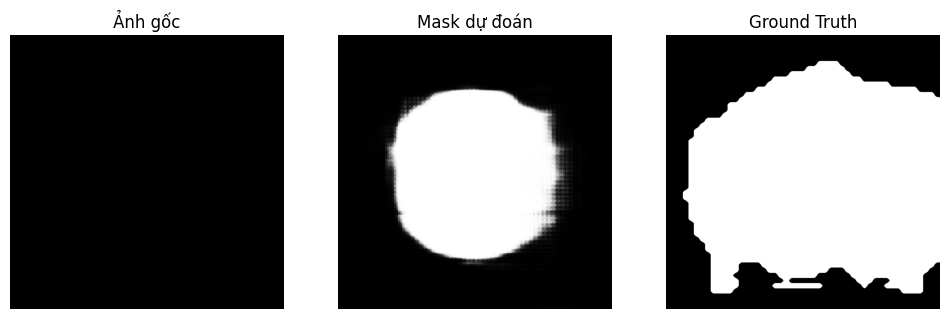

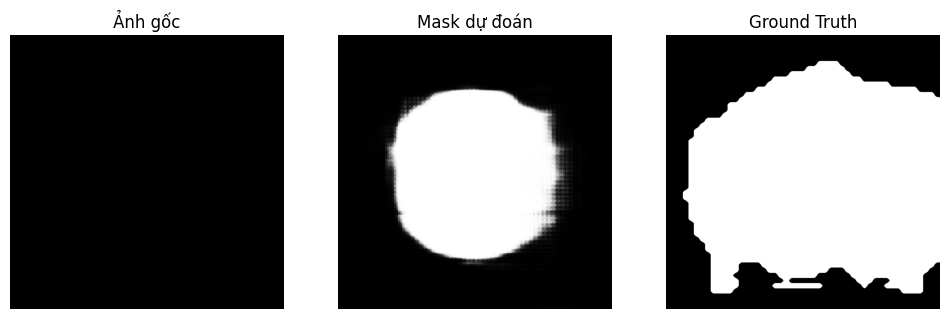

In [ ]:
sample = next(iter(val_dataloader))
img_sample, mask_sample, _ = sample
visualize_output(sam_base, img_sample[0], mask_sample)
visualize_output(sam_lora, img_sample[0], mask_sample)


In [ ]:
# Kiểm tra các tham số nào đang được huấn luyện
for name, param in sam_lora.named_parameters():
    if param.requires_grad:
        print(name)


In [ ]:
num_trainable = 0
for name, param in sam_lora.named_parameters():
    if param.requires_grad:
        print("🔧", name)
        num_trainable += 1

print(f"\n✅ Số lượng tham số đang huấn luyện: {num_trainable}")



✅ Số lượng tham số đang huấn luyện: 0


In [ ]:
print(sam_lora.print_trainable_parameters())


trainable params: 0 || all params: 93,746,736 || trainable%: 0.0
None
